In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import os 
from scipy import interpolate

In [2]:
from matplotlib import animation
#import seaborn as sbn         # not available in the environment yet.

In [3]:
import ipywidgets as widgets

In [4]:
%matplotlib inline

In [5]:
# specify the data path:
datadir = r'/data/xchen/BB2017'

folder1 = 'OUT_2D'
folder2 = 'OUT_3D'    # 
folder3 = 'OUT_STAT'  # time-varying, horizontally-averaged profiles of domain-mean quantities

filename_stat = 'S6_CTL_512sqx128_250m_testf.nc'
file_prefix = 'S6_CTL_512sqx128_250m_testf'
#filename_3D = 'S6_CTL_MSE_512sqx128_250m_testf_0128_CONCAT.nc'


# establish a dictionary for the filename:
filenames=dict()
filenames['cntrl']=file_prefix + '.nc'
filenames['noPCP'] = file_prefix + '_noPCP.nc'
filenames['RADhomo'] = file_prefix + '_RADhomo.nc'
filenames['RADFLXhomo']=file_prefix + '_RADFLXhomo.nc'
filenames['RFhomoNoPCP']=file_prefix + '_RADFLXhomo_noPCP.nc'
filenames['WTG'] = file_prefix + '_WTG.nc'


In [6]:
figsvdir = r'/home/xchen/jupyter_notebook/LES/BB2017_analysis/output/'

In [7]:
# manually select a simulation case to make the evolution movie:
testcase_label='cntrl'
filename_stat = filenames[testcase_label]
print(filename_stat)
absfn = os.path.join(datadir, folder3, filename_stat)
ds_stat = xr.open_dataset(absfn)


S6_CTL_512sqx128_250m_testf.nc


In [8]:
# domain mean thermodynamci:
# compute the virtual liquid static energy:
# note that Lv and Cp are set to the same value as used in the SAM model.
Lv = 2.5104*10**6
mu = 0.93
Cp = 1003.5
ds_stat['Svl'] = ds_stat.MSE - mu*Lv*(ds_stat.QT/1000)/Cp    #units is K.


In [9]:
# here define a function to compute the totoal water mixing ratio matrix from a h-svl grid:
def compute_qt_contours(h_TempRange,svl_TempRange, inc):
    """
     h_range: a list type input specifying the lower and upper limit for MSE
     svl_range: idem but for the virtual liquid static energy
     return the meshgrid: ssvl, hh, qt_cont
    """
    Lv = 2.5104*10**6
    mu = 0.93
    Cp = 1003.5
    h_gridvec = np.linspace(h_TempRange[0],h_TempRange[1],inc)
    Svl_gridvec = np.linspace(svl_TempRange[0],svl_TempRange[1],inc)
    
    ssvl, hh = np.meshgrid(Svl_gridvec, h_gridvec)
    qt_cont = (hh - ssvl)/(mu*Lv/Cp)*1000 # g/kg
    return ssvl, hh, qt_cont

In [10]:
# try to do the tracing of the midpoints in different layers:
nt = len(ds_stat.time)
nz = 300    # number of vertical levs between the inversion height and the surface.
MSE_fine = np.zeros([nt, nz])
Svl_fine = np.zeros([nt, nz])
z_fine = np.zeros([nt, nz])
z_fine_normalized =  np.zeros([nt, nz])
alpha = np.zeros([nt,nz])

for i in range(nt):
    z_fine[i, :]= np.linspace(ds_stat.z[0], ds_stat.ZINV[i]*1000, nz)
    z_fine_normalized[i,:] = z_fine[i,:]/(ds_stat.ZINV[i].values*1000*np.ones([1,nz]))
    f_MSE = interpolate.interp1d(ds_stat.z, ds_stat.MSE[i,:])
    f_Svl = interpolate.interp1d(ds_stat.z, ds_stat.Svl[i,:])
    MSE_fine[i,:] = f_MSE(z_fine[i,:])
    Svl_fine[i,:] = f_Svl(z_fine[i,:])
    # alpha = - dh/dz / ds/dz = -dh / ds
    alpha[i,:] = -np.gradient(MSE_fine[i,:], Svl_fine[i,:])
    

    

/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1084: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1084: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1085: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1085: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1086: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.p

In [12]:
simT = (ds_stat.time-ds_stat.time[0])*24   # units = hr

interactive(children=(IntSlider(value=180, description='i', max=431, step=36), Output()), _dom_classes=('widge…

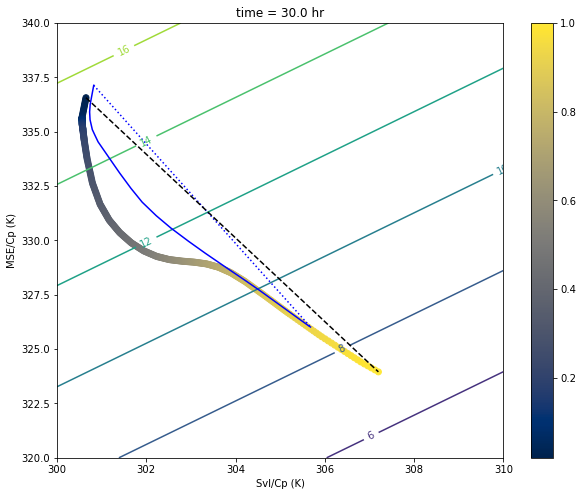

In [26]:
# build a slider to slide throught the evolution of the results below:
# also try making a movie?
@widgets.interact( i=(0, nt-1, 36))
def check_MSE_Svl_v2(i):
    fig, ax = plt.subplots(1,1, figsize=(10,8))
    
    ax.plot(Svl_fine[0,:], MSE_fine[0,:], color='b')
    hsc=ax.scatter(Svl_fine[i,:], MSE_fine[i,:], c=z_fine_normalized[i,:], cmap=cm.cividis)
    
    # plot the mixing line:
    ax.plot([Svl_fine[0,0],Svl_fine[0,-1]],[MSE_fine[0,0],MSE_fine[0,-1]],color='b', 
           linestyle=':')
    
    ax.plot([Svl_fine[i,0],Svl_fine[i,-1]],[MSE_fine[i,0],MSE_fine[i,-1]],color='k', 
           linestyle='--')
   
    hb = fig.colorbar(hsc,ax=ax)
            
   

      #ax.plot(Svl_fine[0:i,-1], MSE_fine[0:i,-1],color='r')
    
#     # put markers on every 6 hours:
#     ax[0].plot(Svl_fine[0:i:36,-1],MSE_fine[0:i:36,-1],linestyle='none',
#            marker='*',color='r')

#     # mixed layer: at 20% of the inversion:
#     ax[0].plot(Svl_fine[0:i,60], MSE_fine[0:i,60],color='c')
#     # put markers on every 6 hours:
#     ax[0].plot(Svl_fine[0:i:36,60],MSE_fine[0:i:36,60],linestyle='none',
#            marker='*',color='c')

#     # mixed layer: at 50% of the inversion:
#     ax[0].plot(Svl_fine[0:i,150], MSE_fine[0:i,150],color='m')
#     # put markers on every 6 hours:
#     ax[0].plot(Svl_fine[0:i:36,150],MSE_fine[0:i:36,150],linestyle='none',
#            marker='*',color='m')

#     # mixed layer: at 75% of the inversion:
#     ax[0].plot(Svl_fine[0:i,225], MSE_fine[0:i,225],color='k')
#     # put markers on every 6 hours:
#     ax[0].plot(Svl_fine[0:i:36,225],MSE_fine[0:i:36,225],linestyle='none',
#            marker='*',color='k')
    
    ax.set_xlim(300,310)
    ax.set_ylim(320,340)
    titlestr = "time = {0:.1f} hr".format(simT[i].values)
    ax.set_title(titlestr)
    
    h_TempRange=[320,340]
    svl_TempRange=[300,310]
    
    # add total water mixing ratio contours onto this plot:
    ssvl, hh, qt_cont = compute_qt_contours(h_TempRange,svl_TempRange, 21)
    # add humidity contours:
    cs=ax.contour(ssvl,hh,qt_cont)
    ax.clabel(cs,cs.levels,inline=True, fontsize=10)
    ax.set_xlabel('Svl/Cp (K)')
    ax.set_ylabel('MSE/Cp (K)')

    
    ### ----- second plot: show profile of alpha: ----- ###
    #ax[1].plot(alpha[i,:], z_fine[i,:],color='k')
#     ax[1].scatter(alpha[i,:], z_fine[i,:], c=z_fine_normalized[i,:],cmap=cm.cividis)
    
#     ax[1].set_xlabel('alpha')
#     ax[1].set_ylabel('altitude (m)')
#     ax[1].set_ylim(0,z_fine[i,-1])
#     ax[1].grid(True)
#     # make twin axes:
    
#      # set a twin axes to plot graident :
#     ax2=ax[1].twinx()
#     color = 'tab:blue'
#     ax2.set_ylabel('Z/Zinv', color=color)  # we already handled the x-label with ax1
#     ax2.plot(alpha[i,:], z_fine_normalized[i,:], color=color)
#     ax2.plot(alpha[0,:], z_fine_normalized[0,:],color='b',linestyle='--')
#     ax2.tick_params(axis='y', labelcolor=color)
#     ax2.set_ylim(0,1)
#     #ax2.set_xlim(-20,20)
# #     ax2.set_xlim(10**(-4),500)                
# #     ax2.set_xscale('log')
#     ax2.set_xlim(-50,50)                
#     ax2.set_xscale('linear')
#     #ax2.grid(True)
    
    plt.show()
    
    return fig
    

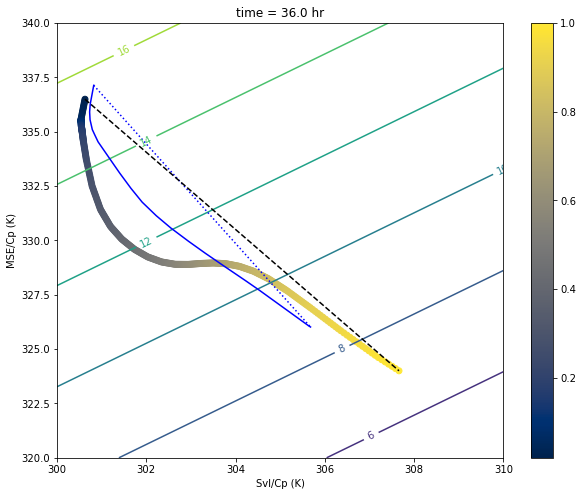

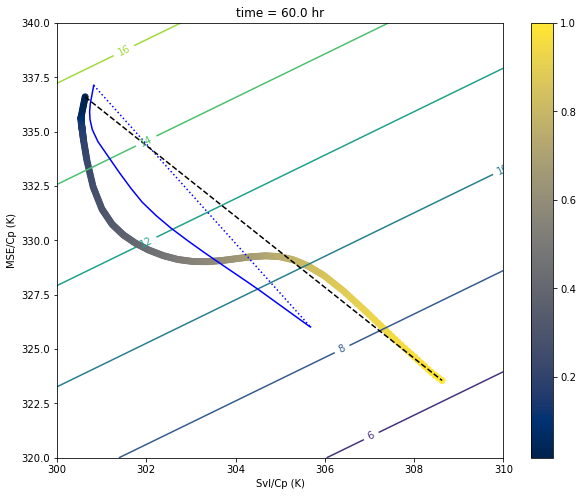

In [27]:
# output these plots again (this time the )
#tlist = [0, 36*2, 36*4, 36*8, 36*11]   #36*8
tlist = [6*36, 6*60]
for it in tlist:
    fig = check_MSE_Svl_v2(i=it)
    figname = figsvdir + 'h_svl_test_{0:.0f}hr_'.format(np.round(simT[it].values)) + testcase_label + '.jpg'
    fig.savefig(figname)